In [1]:
import os
os.environ['DRJIT_LIBLLVM_PATH'] = 'C:\\Program Files\\LLVM\\bin\\LLVM-C.dll'
#print(os.environ['DRJIT_LIBLLVM_PATH'])
import sionna
import mitsuba as mi
import drjit as dr
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
from IPython.display import display, HTML
# Import Sionna RT components
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, Camera, Antenna, AntennaArray
# For link-level simulations
from sionna.channel import cir_to_ofdm_channel, subcarrier_frequencies, OFDMChannel, ApplyOFDMChannel, CIRDataset
from sionna.nr import PUSCHConfig, PUSCHTransmitter, PUSCHReceiver
from sionna.utils import compute_ber, ebnodb2no, PlotBER
from sionna.ofdm import KBestDetector, LinearDetector
from sionna.mimo import StreamManagement
from Movement import *
from Visualization import *
from helper import *
from Channel import *
from Codebook import *
import math

In [2]:
#tf.random.set_seed(10)
itu_metal_scattering_coefficient = 0.707 # To define the  scattering coefficient based on Sionna R = sqrt(1-S**2)
itu_concrete_scattering_coefficient = 0.707 # To define the  scattering coefficient based on Sionna R = sqrt(1-S**2)

c = 299792458.0 # m/s
# tx and rx in cartesian coordinate
tx_position = [0,0.25,.94]
rx_position = [0,-0.25,.94]
N_t = 1
N_r = 16
L_r = 16
L_t = 1

initial_position_cartesian = cylindrical_to_cartesian([3, math.radians(33), 0])
initial_position_cartesian 

array([2.5160117 , 1.63391711, 0.        ])

In [3]:
scene = load_scene('C:\\Users\\dehghani\\Documents\\test_scene\\scene.xml')

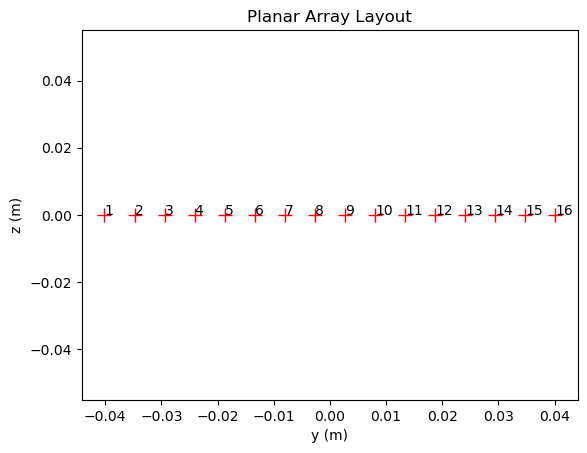

In [4]:
scene.frequency = 28e9

scene.synthetic_array = True # If set to False, ray tracing will be done per antenna element (slower for large arrays)

scene.tx_array = PlanarArray(num_rows=1,
                          num_cols = N_t,
                          vertical_spacing = 0.5,
                          horizontal_spacing= 0.5,
                          pattern="iso",
                          polarization="H")


scene.rx_array = PlanarArray(num_rows=1,
                          num_cols = N_r,
                          vertical_spacing= 0.5,
                          horizontal_spacing= 0.5,
                          pattern="iso",
                          polarization="H")

scene.rx_array.show()

# Create transmitter
tx = Transmitter(name = "tx",
                 position = tx_position)


# Add transmitter instance to scene
scene.add(tx)

# Create a receiver
rx = Receiver(name = "rx",
              position = rx_position)

# Add receiver instance to scene
scene.add(rx)

In [5]:
for rm in scene.radio_materials.values():
    if rm.name=='itu_metal' :
        print(f'Before: rm.name: {rm.name} and   rm.scattering_coefficient = { rm.scattering_coefficient}')
        rm.scattering_coefficient= itu_metal_scattering_coefficient
        print(f'After: rm.name: {rm.name} and   rm.scattering_coefficient = { rm.scattering_coefficient}')
        
    if rm.name=='itu_concrete' :
        rm.scattering_coefficient = itu_concrete_scattering_coefficient

   #     rm.scattering_pattern = BackscatteringPattern(alpha_r=20, alpha_i=30, lambda_=0.5)

Before: rm.name: itu_metal and   rm.scattering_coefficient = 0.0
After: rm.name: itu_metal and   rm.scattering_coefficient = 0.7070000171661377


In [6]:
params = mi.traverse(scene._scene)
positions = dr.unravel(mi.Point3f, params['mesh-Robot.vertex_positions'])

positions.x += initial_position_cartesian[0]
positions.y += initial_position_cartesian[1]
positions.z += initial_position_cartesian[2]

params['mesh-Robot.vertex_positions'] = dr.ravel(positions)
params.update()

[(PLYMesh[
    name = "Robot.ply",
    bbox = BoundingBox3f[
      min = [1.96601, 1.38392, 0.84],
      max = [3.06601, 1.88392, 1.04]
    ],
    vertex_count = 14,
    vertices = [280 B of vertex data],
    face_count = 12,
    faces = [144 B of face data],
    face_normals = 1
  ],
  {'vertex_positions'}),
 (Scene[
    children = [
      PathIntegrator[
        max_depth = 12,
        rr_depth = 5
      ],
      TwoSided[
        brdf[0] = SmoothDiffuse[
          reflectance = SRGBReflectanceSpectrum[
            value = [[0.8, 0.043496, 0.011812]]
          ]
        ],
        brdf[1] = SmoothDiffuse[
          reflectance = SRGBReflectanceSpectrum[
            value = [[0.8, 0.043496, 0.011812]]
          ]
        ]
      ],
      ConstantBackgroundEmitter[
        radiance = SRGBReflectanceSpectrum[
          value = [[1, 1, 1]]
        ],
        bsphere = BoundingSphere3f[
          center = [0, 0, 0.94],
          radius = 0.612427
        ]
      ],
      PLYMesh[
        

In [7]:
scene._solver_paths = Solver(scene)
paths = scene.compute_paths(method='fibonacci', max_depth=1, num_samples=1e7, reflection=False, scattering=True,
                                    diffraction=False, los=False)
paths.normalize_delays = False
a, tau = paths.cir(los=False, reflection=False, diffraction=False, scattering=True)

In [8]:
scene.preview(paths, show_devices=True, show_paths=True) 

Renderer(camera=PerspectiveCamera(aspect=1.31, children=(DirectionalLight(intensity=0.25, position=(0.0, 0.0, …

In [9]:
# a = [batch_size, num_rx, num_rx_ant, num_tx, num_tx_ant, max_num_paths, num_time_steps], tf.complex
a

<tf.Tensor: shape=(1, 1, 16, 1, 1, 19, 1), dtype=complex64, numpy=
array([[[[[[[-2.64154414e-06-2.5201948e-06j],
            [ 2.76714854e-06-9.8668249e-07j],
            [ 3.52035113e-06+1.6914657e-06j],
            [-2.77285608e-06-6.6705445e-07j],
            [ 2.64196842e-07+2.6588693e-06j],
            [-3.46316756e-06+5.0598288e-08j],
            [ 1.28750787e-06+3.4174900e-06j],
            [ 1.37786458e-06-2.8911836e-06j],
            [-3.65306732e-06+2.0218670e-07j],
            [-3.42864087e-06-2.5421821e-07j],
            [ 2.75064690e-06-2.6689772e-06j],
            [ 1.16662989e-06+2.5277943e-06j],
            [-2.65313724e-06+1.0978108e-06j],
            [-3.38471295e-06-2.0148773e-06j],
            [-3.47837022e-06+1.7654488e-06j],
            [ 1.23924121e-06-3.4025702e-06j],
            [ 2.46121613e-06+1.0929442e-06j],
            [ 3.78008781e-06-1.6351426e-06j],
            [ 3.98645534e-06-7.0992292e-07j]]]],



         [[[[ 3.34546257e-06-1.4618539e-06j],
       

In [10]:
# Azimuth angle of arrival and departure
azimuth_departure_list = []
azimuth_arrival_list = []

for path_idx in range(a.shape[-2]):
    azimuth_departure_list.append(np.rad2deg(paths.phi_t[0,0,0,path_idx]))
    azimuth_arrival_list.append(np.rad2deg(paths.phi_r[0,0,0,path_idx]))

[38.809464,
 32.835323,
 42.163094,
 32.112198,
 30.593796,
 37.221775,
 44.875828,
 35.03884,
 44.808777,
 36.999866,
 42.970657,
 31.526745,
 32.259583,
 41.8199,
 42.2322,
 45.19741,
 30.772657,
 39.820175,
 40.58624]

# Receiving Codebook

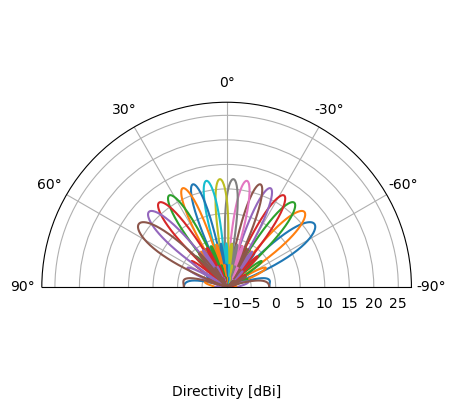

array([-52.83802756, -45.79295722, -38.74788688, -31.70281654,
       -24.6577462 , -17.61267585, -10.56760551,  -3.52253517,
         3.52253517,  10.56760551,  17.61267585,  24.6577462 ,
        31.70281654,  38.74788688,  45.79295722,  52.83802756])

In [11]:
receiving_codebook = Codebook(L_max = L_r , N1 = N_r, az_min = -60, az_max = 60)
receiving_codebook_vectors, beam_degs = receiving_codebook.beamforming_vectors()
receiving_codebook.plot_beamforming_polar(receiving_codebook_vectors)
beam_degs

In [12]:
receiving_codebook_vectors

[array([ 2.50000000e-01+0.j        , -2.07867403e-01-0.13889256j,
         9.56708581e-02+0.23096988j,  4.87725805e-02-0.24519632j,
        -1.76776695e-01+0.1767767j ,  2.45196320e-01-0.04877258j,
        -2.30969883e-01-0.09567086j,  1.38892558e-01+0.2078674j ,
        -2.45084105e-16-0.25j      , -1.38892558e-01+0.2078674j ,
         2.30969883e-01-0.09567086j, -2.45196320e-01-0.04877258j,
         1.76776695e-01+0.1767767j , -4.87725805e-02-0.24519632j,
        -9.56708581e-02+0.23096988j,  2.07867403e-01-0.13889256j]),
 array([ 0.25      +0.j        , -0.15859832-0.19325261j,
        -0.04877258+0.24519632j,  0.22048032-0.11784918j,
        -0.23096988-0.09567086j,  0.07257117+0.23923508j,
         0.13889256-0.2078674j , -0.24879618+0.02450429j,
         0.1767767 +0.1767767j ,  0.02450429-0.24879618j,
        -0.2078674 +0.13889256j,  0.23923508+0.07257117j,
        -0.09567086-0.23096988j, -0.11784918+0.22048032j,
         0.24519632-0.04877258j, -0.19325261-0.15859832j]),
 arr

In [13]:
# Removing the redundant dimesions from a --> (batch size (rays), receiving antennas, transmitting antennas)
a_reshaped = tf.squeeze(a, [0,1,3,6])
a_reshaped = tf.transpose(a_reshaped, perm=[2, 0, 1]) 

In [14]:
# Generating a matrix out of receiving_codebook_vectors --> # (batch size, N_r, L_r)
receiving_codebook_matrix = np.stack(receiving_codebook_vectors, axis = -1)  # (N_r, L_r)
# Add the dummy batch dimension
receiving_codebook_matrix = np.expand_dims(receiving_codebook_matrix, axis=0).astype(np.complex64)  

In [15]:
# Beam forming at the receiver by applying the weights 
# (batch size, N_r, L_r) * (batch size (rays), N_r, N_t) = (batch size, L_r, N_t))

beam_formed_receiving_signal = tf.matmul(receiving_codebook_matrix, a_reshaped, adjoint_a=True) 
beam_formed_receiving_signal # (batch size, L_r, N_t)

<tf.Tensor: shape=(19, 16, 1), dtype=complex64, numpy=
array([[[-1.17542572e-06-1.25649649e-07j],
        [-3.68755565e-07-6.27002919e-07j],
        [-1.31000206e-08+3.08961887e-08j],
        [-6.68648738e-07+1.61588162e-07j],
        [-6.67245104e-07+2.72179932e-08j],
        [-5.75462650e-07-7.13219549e-07j],
        [-4.42066494e-07-8.43859766e-07j],
        [-2.91676884e-07-9.91140155e-07j],
        [-1.05710512e-07-1.17326465e-06j],
        [ 1.52444613e-07-1.42608258e-06j],
        [ 5.74837486e-07-1.83974316e-06j],
        [ 1.73633225e-06-6.05025036e-07j],
        [ 4.14647047e-06-5.79861307e-07j],
        [-1.02381127e-05-1.04098826e-05j],
        [-7.14527800e-07+4.55552936e-06j],
        [-2.80322138e-06+1.46850357e-06j]],

       [[ 4.22018445e-07+6.59911166e-08j],
        [-9.88315492e-08-1.88445455e-07j],
        [ 2.87421926e-07-5.95560778e-07j],
        [ 7.00116914e-07-1.33558018e-07j],
        [ 7.10364816e-07+5.57602675e-09j],
        [ 2.19437254e-07+3.00783881e-07j

In [16]:
def beamforming_gain(a_reshaped, beam_formed_signal, N):

    receiving_signal_mag = np.abs(a_reshaped)
    beam_formed_receiving_signal_mag = np.abs(beam_formed_receiving_signal)
    gain = beam_formed_receiving_signal_mag / receiving_signal_mag[:, :1, :1]
    gain = gain * math.sqrt(N_r)
    return gain
     
        
gain = beamforming_gain(a_reshaped = a_reshaped, beam_formed_signal = beam_formed_receiving_signal,N=N_r)

In [17]:
# Create a MultiIndex with two levels for rows
multi_index = pd.MultiIndex.from_product([range(1, gain.shape[0] + 1, 1), range(1, gain.shape[1] + 1, 1)], names=['batch_size', 'beams'])

# Create a DataFrame with the MultiIndex
df = pd.DataFrame(gain.reshape(-1, 1), index=multi_index, columns=['gain'])

# Repeat each element of the lists 4 times
azimuth_departure_repeated = np.repeat(azimuth_departure_list, L_r)
azimuth_arrival_repeated = np.repeat(azimuth_arrival_list, L_r)

# Add new columns to the DataFrame
df['azimuth_arrival'] = azimuth_arrival_repeated
df['azimuth_departure'] = azimuth_departure_repeated
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(df)

                       gain  azimuth_arrival  azimuth_departure
batch_size beams                                               
1          1       1.295154        38.809464          29.168884
           2       0.796954        38.809464          29.168884
           3       0.036767        38.809464          29.168884
           4       0.753672        38.809464          29.168884
           5       0.731653        38.809464          29.168884
           6       1.004054        38.809464          29.168884
           7       1.043729        38.809464          29.168884
           8       1.131956        38.809464          29.168884
           9       1.290656        38.809464          29.168884
           10      1.571343        38.809464          29.168884
           11      2.111756        38.809464          29.168884
           12      2.014538        38.809464          29.168884
           13      4.587152        38.809464          29.168884
           14     15.996939        38.80

In [26]:
## This cell is to check the result with matrix multiplication.

#for i in range(a_reshaped.shape[0]):  # Iterate over the first dimension which is batch size (rays)
    
#    single_batch = a_reshaped[i, :, :]
    
#    print(f"single batch {i + 1}:\n{single_batch.numpy()}\n")
#    print(f"Azimuth angle of departure: {np.rad2deg(paths.phi_t[0,0,0,i]):.4f}\n")
#    print(f"Azimuth angle of arrival: {np.rad2deg(paths.phi_r[0,0,0,i]):.4f}\n")
    
#    for beam in receiving_codebook_vectors:
    
#        beam = beam.astype(np.complex64)
#        beam_reshaped = np.reshape(beam, (N_r, 1))
#        transposed_conjugate_beam = beam_reshaped.T.conj()
#        beam_formed_single_batch = transposed_conjugate_beam @ single_batch
#        print(beam_formed_single_batch)
#        #beam_formed_single_batch_mag = tf.abs(beam_formed_single_batch)   
#        #print(beam_formed_single_batch_mag * math.sqrt(N_r))


In [19]:
# tau = [batch_size, num_rx, num_tx, max_num_paths]
tau = tf.squeeze(tau)
tau

<tf.Tensor: shape=(19,), dtype=float32, numpy=
array([1.6467860e-08, 1.9315848e-08, 1.6681113e-08, 1.9733850e-08,
       2.0679771e-08, 1.7125259e-08, 1.7421463e-08, 1.8140284e-08,
       1.7400536e-08, 1.7219028e-08, 1.6883462e-08, 2.0079321e-08,
       1.9637962e-08, 1.6589579e-08, 1.6693740e-08, 1.7518079e-08,
       2.0564123e-08, 1.6128158e-08, 1.6302277e-08], dtype=float32)>

In [21]:
# Reshape the tensor to a 2D array
reshaped_array = tf.reshape(beam_formed_receiving_signal, (tau.shape[0], L_r * L_t))
columns = [f'{i},{j}' for i in range(1, L_r + 1) for j in range(1, L_t + 1)]
df1 = pd.DataFrame(reshaped_array.numpy(), columns=columns)
df1 = df1.set_index(pd.Index(tau))
df1

,"1,1","2,1","3,1","4,1","5,1","6,1","7,1","8,1","9,1","10,1","11,1","12,1","13,1","14,1","15,1","16,1"
1.646786e-08,-1.175426e-06-1.256496e-07j,-3.687556e-07-6.270029e-07j,-1.310002e-08+3.089619e-08j,-6.686487e-07+1.615882e-07j,-6.672451e-07+2.721799e-08j,-5.754626e-07-7.132195e-07j,-4.420665e-07-8.438598e-07j,-2.916769e-07-9.911402e-07j,-1.057105e-07-1.173265e-06j,1.524446e-07-1.426083e-06j,5.748375e-07-1.839743e-06j,1.736332e-06-6.050250e-07j,4.146470e-06-5.798613e-07j,-1.023811e-05-1.040988e-05j,-7.145278e-07+4.555529e-06j,-2.803221e-06+1.468504e-06j
1.931585e-08,4.220184e-07+6.599112e-08j,-9.883155e-08-1.884455e-07j,2.874219e-07-5.955608e-07j,7.001169e-07-1.335580e-07j,7.103648e-07+5.576027e-09j,2.194373e-07+3.007839e-07j,1.673535e-07+3.611482e-07j,1.049662e-07+4.334545e-07j,2.185942e-08+5.297756e-07j,-1.060154e-07+6.779831e-07j,-3.539938e-07+9.653884e-07j,8.850323e-07-2.609027e-07j,1.156319e-05-1.047296e-06j,-3.268643e-06-3.663781e-06j,5.237085e-07-2.528947e-06j,7.980223e-07-3.697990e-07j
1.668111e-08,3.613368e-07+4.061063e-07j,8.799782e-08-4.221069e-07j,9.072845e-07-4.189600e-07j,8.410027e-07+4.595055e-07j,7.035908e-07+5.883156e-07j,-2.296684e-08+3.936934e-07j,-1.018047e-07+3.911449e-07j,-1.880641e-07+3.883586e-07j,-2.910765e-07+3.850332e-07j,-4.277729e-07+3.806149e-07j,-6.369356e-07+3.738553e-07j,8.040233e-07+3.417224e-07j,1.339438e-06+9.128879e-07j,4.940099e-07+1.237345e-05j,9.454612e-06-7.614975e-06j,1.730251e-06+4.503325e-07j
1.973385e-08,-5.189258e-07-2.728192e-07j,3.169589e-10+2.040622e-09j,-3.659747e-07+3.710216e-07j,-7.093981e-07-1.002677e-07j,-6.761854e-07-2.367303e-07j,-1.538541e-07-4.949611e-07j,-5.830299e-08-5.531032e-07j,5.708273e-08-6.233168e-07j,2.123899e-07-7.178216e-07j,4.549974e-07-8.654469e-07j,9.384731e-07-1.159639e-06j,-9.757116e-09-4.121077e-10j,-1.108469e-05-2.696018e-06j,1.341680e-06+3.177370e-06j,-1.248952e-06+2.116492e-06j,-1.169946e-06+1.233266e-07j
2.067977e-08,2.782699e-07+6.906657e-07j,-1.993422e-07+3.253884e-07j,1.489369e-07-1.321246e-08j,3.756226e-07+4.225965e-07j,2.879571e-07+4.911611e-07j,-2.656532e-07+6.241614e-07j,-4.135248e-07+6.060812e-07j,-5.952891e-07+5.838589e-07j,-8.456291e-07+5.532515e-07j,-1.250346e-06+5.037668e-07j,-2.110571e-06+3.985911e-07j,-1.637168e-06-1.513005e-06j,5.955821e-06+8.195342e-06j,2.412827e-07-7.685080e-07j,1.646082e-06-5.710405e-07j,1.172520e-06+8.000013e-07j
1.712526e-08,-3.643170e-07+8.814978e-07j,-9.247058e-07+2.323975e-07j,-3.487631e-07-2.857629e-07j,-1.168024e-08+2.416314e-07j,-5.727185e-08+2.294077e-07j,-7.043329e-07+2.923930e-07j,-7.828483e-07+1.563583e-07j,-8.726971e-07+6.842953e-10j,-9.858062e-07-1.952845e-07j,-1.146608e-06-4.738840e-07j,-1.419658e-06-9.469733e-07j,-1.353604e-07-2.711870e-06j,1.055332e-06-7.153179e-06j,-1.169483e-05+6.262832e-06j,1.200365e-06+5.665764e-07j,4.620130e-07+2.313201e-06j
1.742146e-08,4.342850e-07-3.832078e-07j,1.073012e-06+2.283269e-07j,3.932145e-07+8.608543e-07j,-1.554276e-07+2.816991e-07j,-1.962386e-07+2.327301e-07j,3.972264e-07+2.481971e-08j,3.901021e-07+1.032537e-07j,3.824786e-07+1.871693e-07j,3.736028e-07+2.848711e-07j,3.621950e-07+4.104745e-07j,3.455048e-07+5.942385e-07j,-7.521115e-07+1.749507e-06j,-1.808255e-06+2.629765e-06j,-6.516724e-06+2.332254e-07j,8.947572e-06+1.120355e-05j,6.081843e-07-2.297771e-06j
1.814028e-08,-2.763124e-07-3.537741e-08j,-3.842503e-07-6.856776e-07j,3.301906e-07-7.356898e-07j,3.770635e-07-8.284235e-08j,3.808956e-07-7.587346e-09j,-1.421714e-07-1.839221e-07j,-1.095098e-07-2.200879e-07j,-7.130609e-08-2.623899e-07j,-2.191496e-08-3.170867e-07j,5.092630e-08-3.977502e-07j,1.822200e-07-5.431360e-07j,2.571147e-06-8.362161e-07j,1.041632e-05-1.235826e-06j,-6.583119e-06-6.978846e-06j,2.965565e-07-1.663363e-06j,-5.598112e-07+2.785460e-07j
1.740054e-08,2.349442e-07+5.034377e-07j,-5.188417e-07+9.587804e-07j,-9.467600e-07+1.354594e-07j,-2.395524e-07-2.420310e-07j,-1.776788e-07-2.689013e-07j,-1.306292e-07+3.592432e-07j,-2.010105e-07+3.314839e-07j,-2.763489e-07+3.017679e-07j,-3.641141e-07+2.671489e-07j,-4.770

In [22]:
channel_magnitude_df = abs_complex_columns(df1)
channel_magnitude_df

,"1,1","2,1","3,1","4,1","5,1","6,1","7,1","8,1","9,1","10,1","11,1","12,1","13,1","14,1","15,1","16,1"
1.646786e-08,1.182122e-06,7.274018e-07,3.355868e-08,6.878967e-07,6.678000e-07,9.164275e-07,9.526395e-07,1.033167e-06,1.178017e-06,1.434207e-06,1.927458e-06,1.838724e-06,4.186819e-06,1.460084e-05,4.611225e-06,3.164578e-06
1.931585e-08,4.271468e-07,2.127895e-07,6.612897e-07,7.127422e-07,7.103867e-07,3.723220e-07,3.980393e-07,4.459828e-07,5.302264e-07,6.862218e-07,1.028244e-06,9.226876e-07,1.161052e-05,4.909921e-06,2.582604e-06,8.795402e-07
1.668111e-08,5.435868e-07,4.311819e-07,9.993461e-07,9.583480e-07,9.171452e-07,3.943627e-07,4.041764e-07,4.314980e-07,4.826760e-07,5.725883e-07,7.385491e-07,8.736290e-07,1.620943e-06,1.238331e-05,1.213991e-05,1.787895e-06
1.973385e-08,5.862716e-07,2.065091e-09,5.211473e-07,7.164491e-07,7.164272e-07,5.183219e-07,5.561676e-07,6.259251e-07,7.485836e-07,9.777632e-07,1.491809e-06,9.765815e-09,1.140784e-05,3.449027e-06,2.457523e-06,1.176428e-06
2.067977e-08,7.446162e-07,3.815952e-07,1.495218e-07,5.654026e-07,5.693492e-07,6.783429e-07,7.337147e-07,8.338227e-07,1.010532e-06,1.348016e-06,2.147879e-06,2.229238e-06,1.013091e-05,8.054948e-07,1.742319e-06,1.419439e-06
1.712526e-08,9.538161e-07,9.534618e-07,4.508837e-07,2.419136e-07,2.364487e-07,7.626130e-07,7.983103e-07,8.726974e-07,1.004963e-06,1.240675e-06,1.706514e-06,2.715246e-06,7.230609e-06,1.326620e-05,1.327360e-06,2.358889e-06
1.742146e-08,5.791819e-07,1.097036e-06,9.464078e-07,3.217330e-07,3.044222e-07,3.980010e-07,4.035356e-07,4.258195e-07,4.698198e-07,5.474253e-07,6.873813e-07,1.904323e-06,3.191466e-06,6.520896e-06,1.433801e-05,2.376897e-06
1.814028e-08,2.785679e-07,7.860039e-07,8.063902e-07,3.860566e-07,3.809712e-07,2.324652e-07,2.458274e-07,2.719063e-07,3.178431e-07,4.009971e-07,5.728882e-07,2.703711e-06,1.048937e-05,9.593839e-06,1.689593e-06,6.252811e-07
1.740054e-08,5.555613e-07,1.090164e-06,9.564015e-07,3.405354e-07,3.223006e-07,3.822561e-07,3.876684e-07,4.091853e-07,4.516056e-07,5.264095e-07,6.613740e-07,1.898892e-06,3.188701e-06,6.659611e-06,1.433136e-05,2.266368e-06
1.721903e-08,9.015947e-07,9.613439e-07,5.052155e-07,1.762508e-07,1.724295e-07,7.238828e-07,7.585019e-07,8.301009e-07,9.572475e-07,1.184125e-06,1.634269e-06,2.785077e-06,7.615374e-06,1.298808e-05,9.437493e-07,2.207323e-06


In [23]:
#m = channel_magnitude_df.query('index > 11e-9').max()
m = channel_magnitude_df.max()
m

1,1     1.263152e-06
2,1     1.125453e-06
3,1     1.069288e-06
4,1     1.042662e-06
5,1     1.004545e-06
6,1     9.599396e-07
7,1     9.935155e-07
8,1     1.072223e-06
9,1     1.215193e-06
10,1    1.467218e-06
11,1    2.147879e-06
12,1    2.785077e-06
13,1    1.161052e-05
14,1    1.608798e-05
15,1    1.435225e-05
16,1    3.576604e-06
dtype: float64

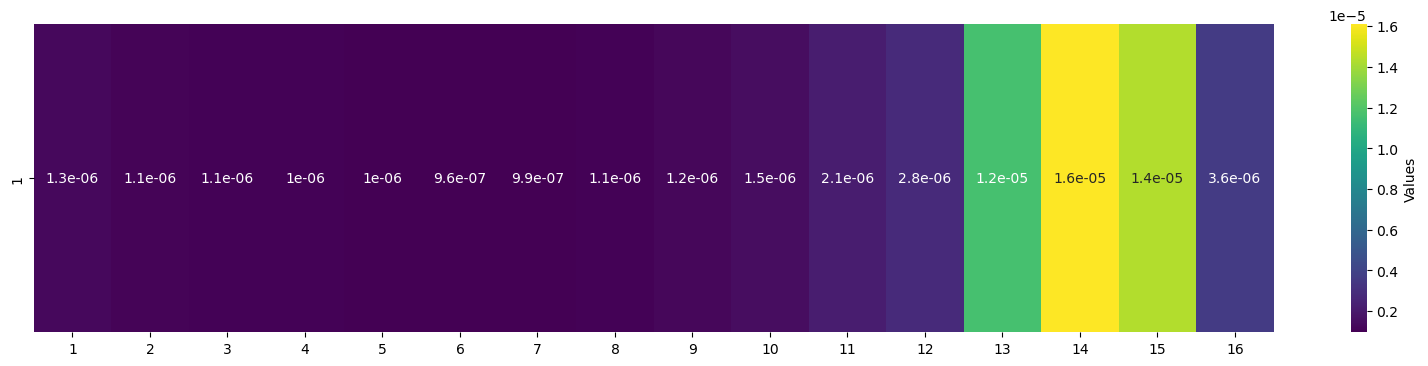

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Reshape the data into a 2D array --> L_t*L_r
data_matrix = m.values.reshape(L_t, L_r)

# Convert index labels to integers
index_labels = [tuple(map(int, index.split(','))) for index in m.index]
rows, cols = zip(*index_labels)

plt.figure(figsize=(20, 4))  
# Create a heatmap using seaborn
sns.heatmap(data_matrix, cmap='viridis', annot=True, cbar_kws={'label': 'Values'})

plt.xticks(np.arange(L_r) + 0.5, range(1, L_r+1))
plt.yticks(np.arange(L_t) + 0.5, range(1, L_t+1))

# Display the heatmap
plt.show()

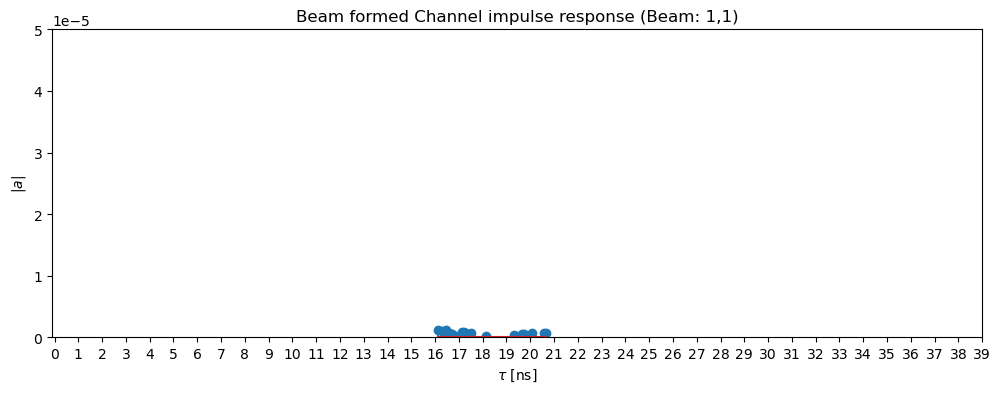

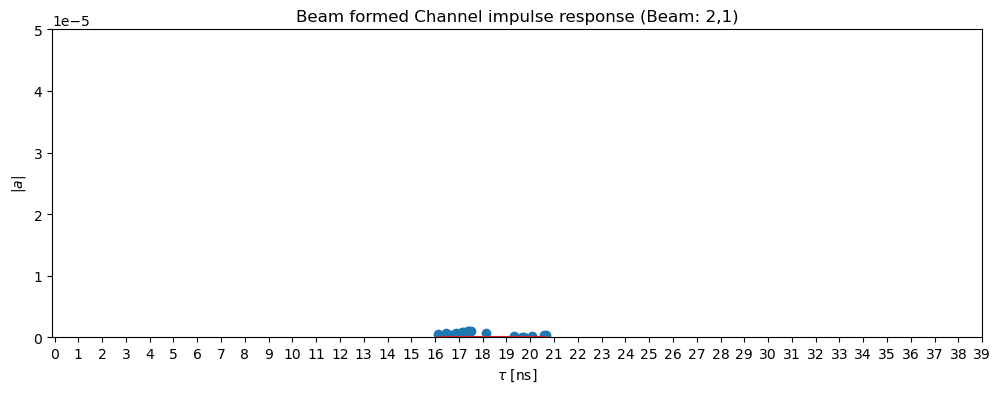

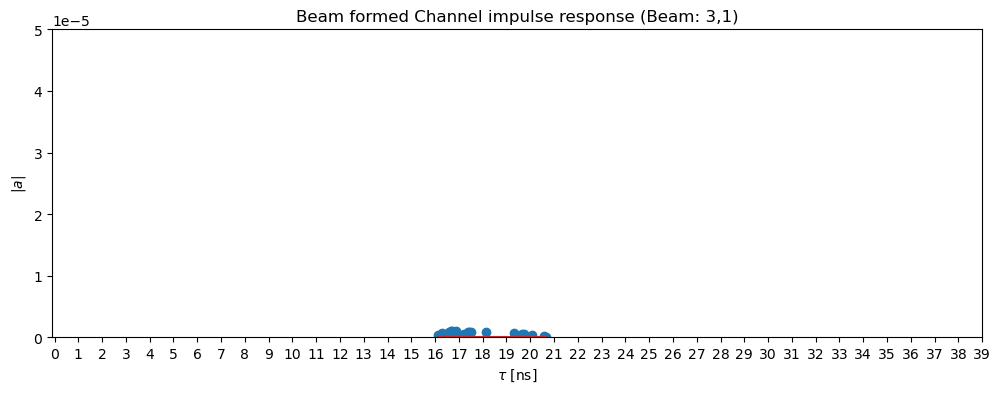

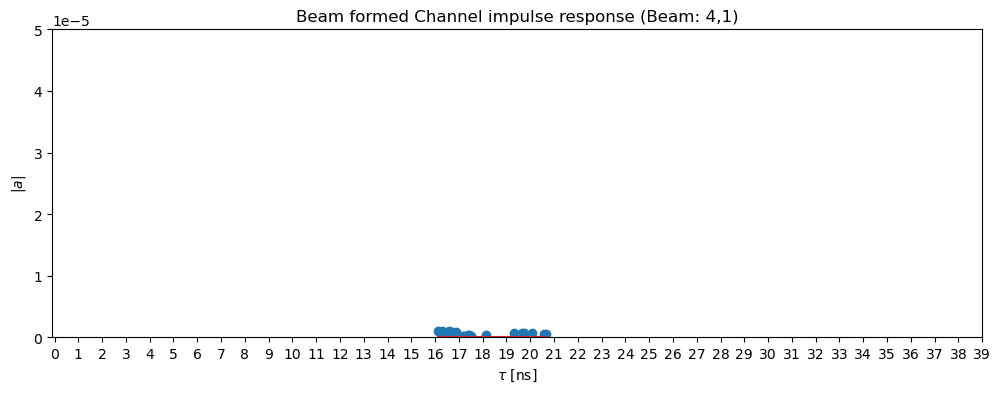

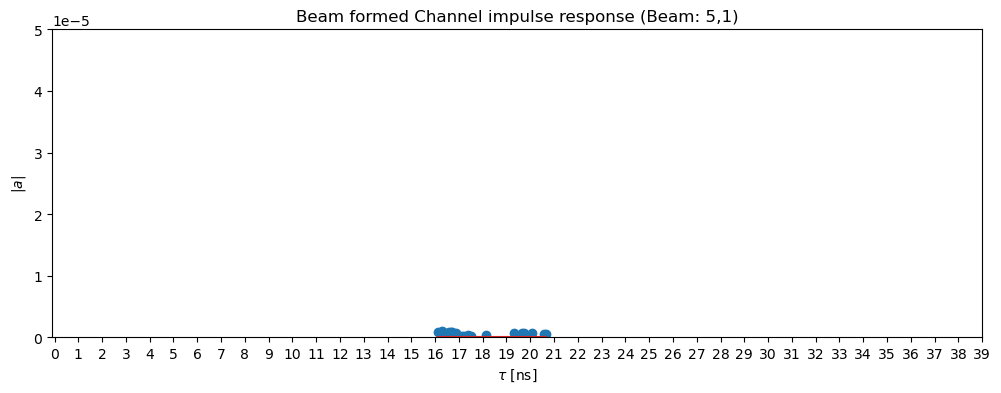

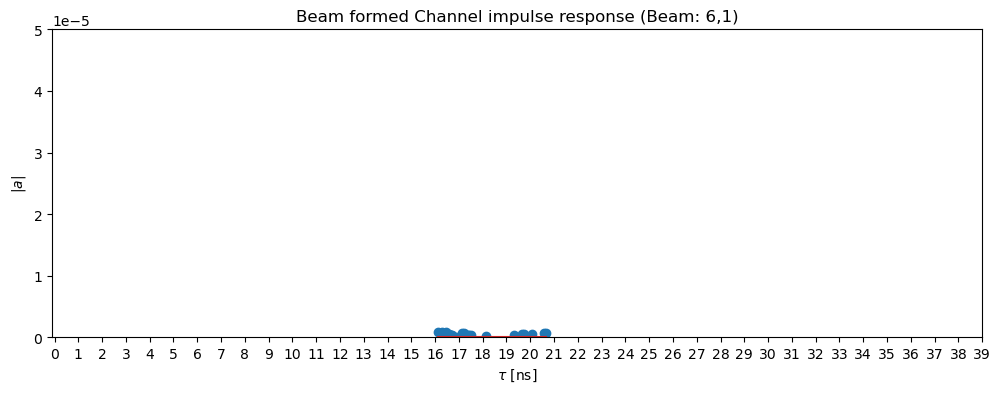

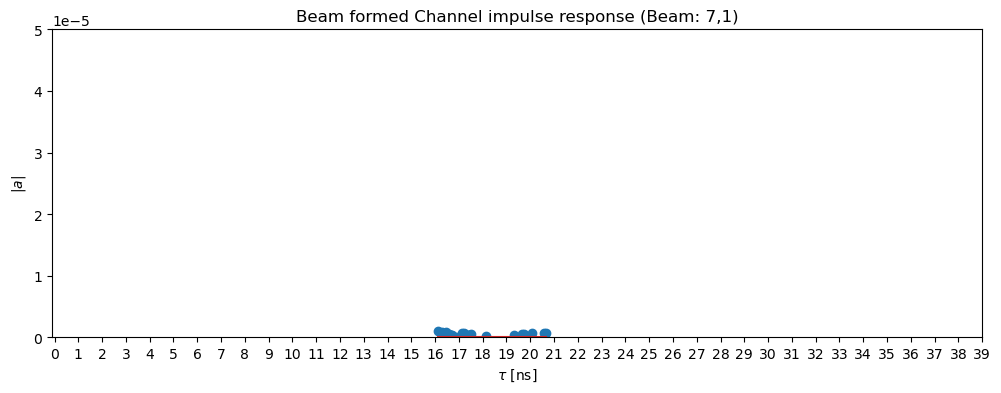

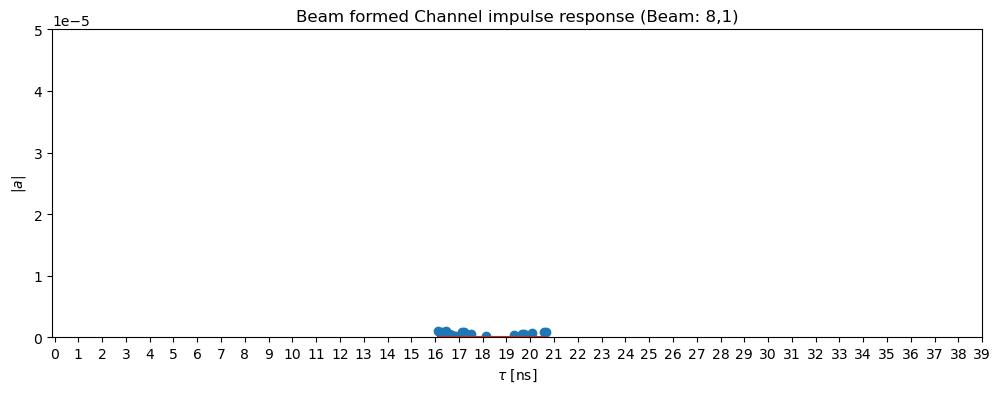

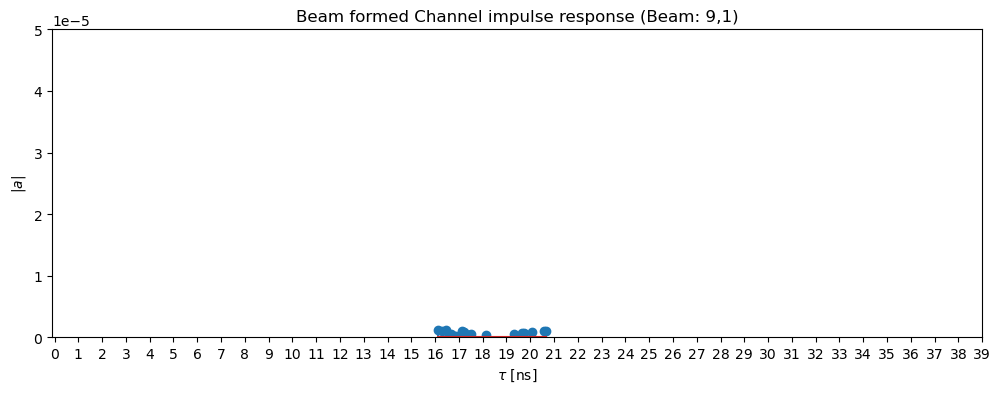

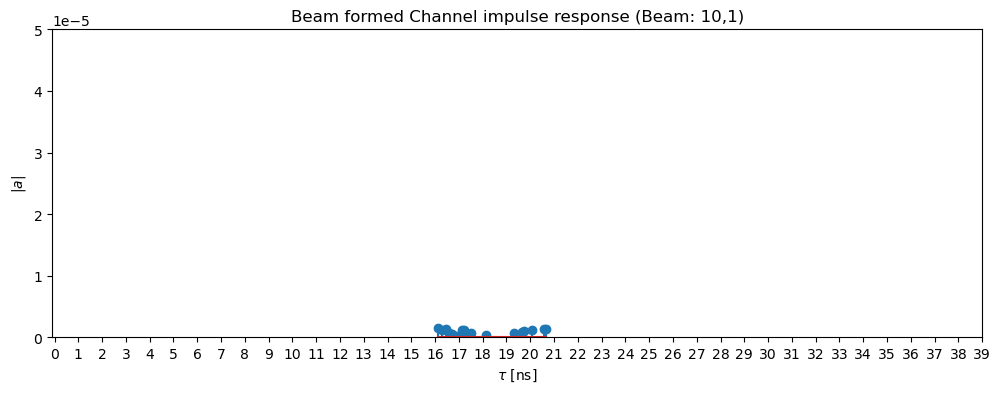

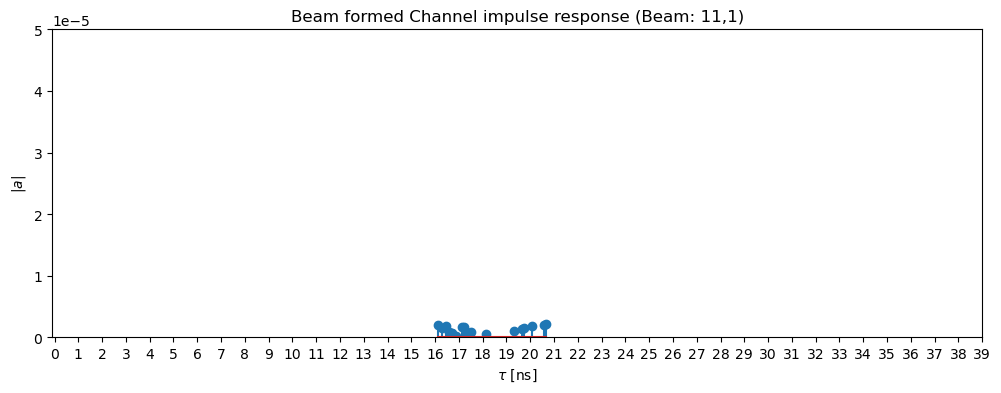

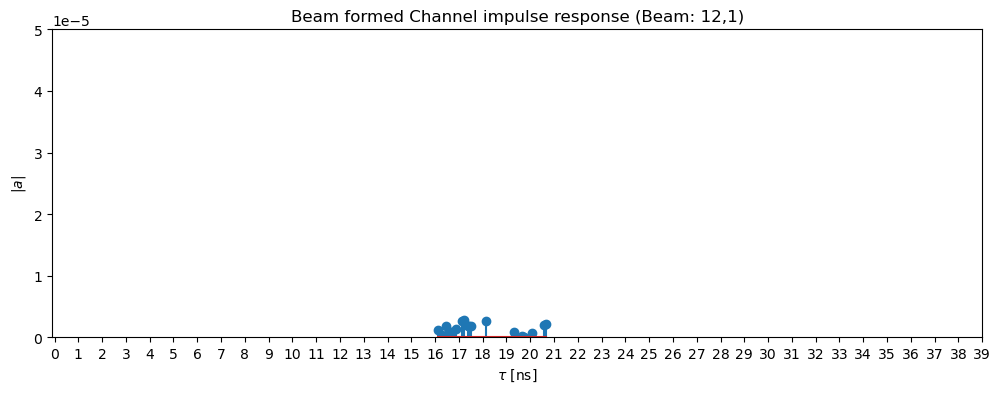

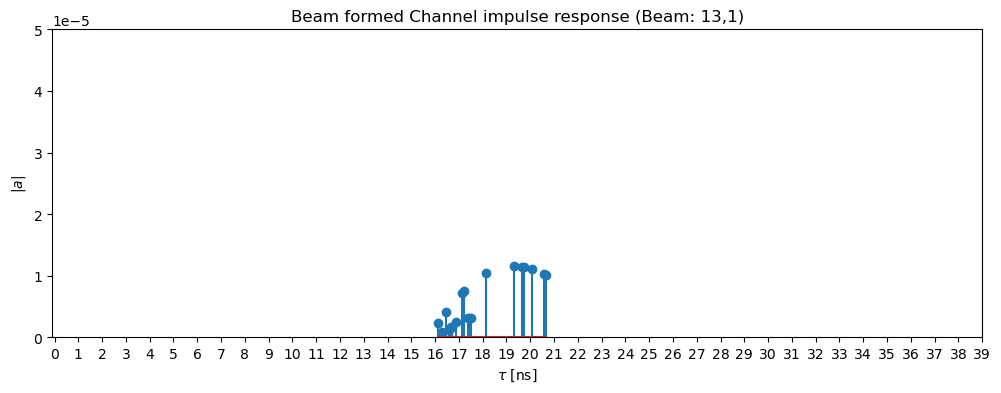

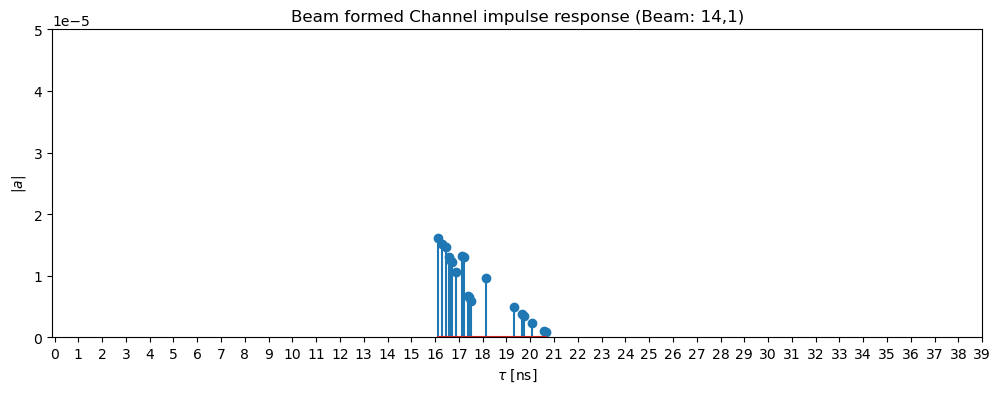

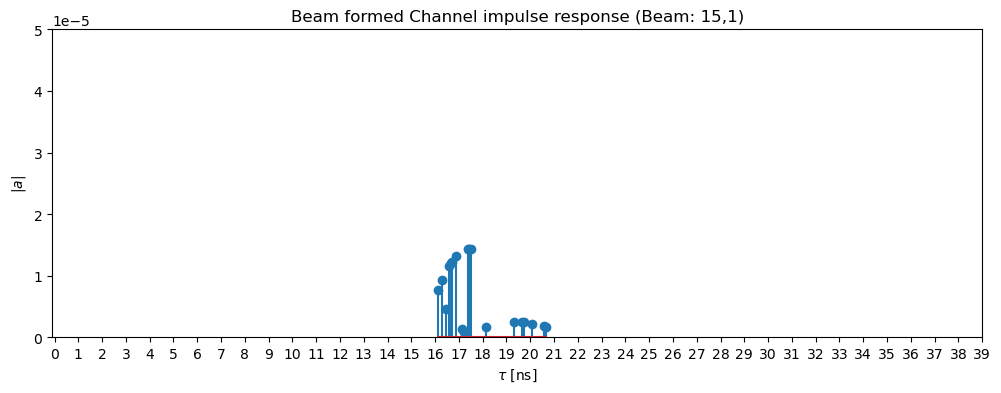

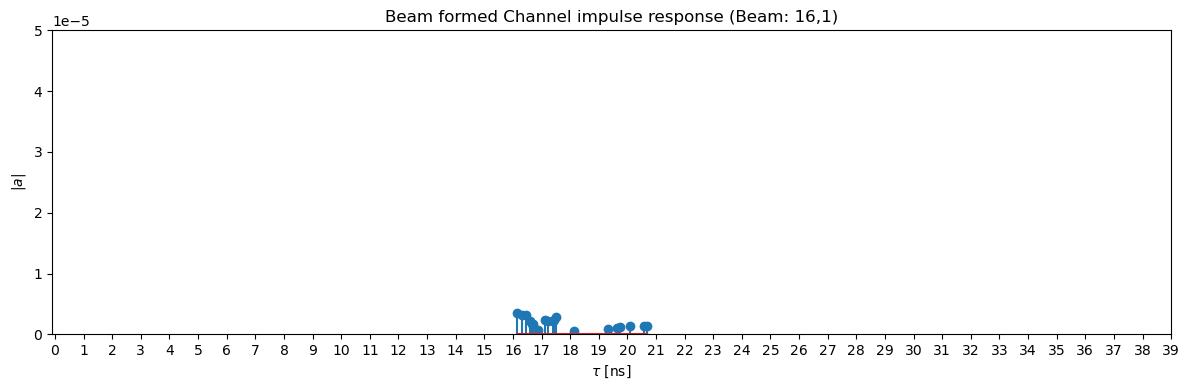

In [25]:
for column in channel_magnitude_df.columns:
    fig, ax = plt.subplots(1, 1, figsize=(12, 4))   
    ax.set_title(f"Beam formed Channel impulse response (Beam: {column})")
    ax.stem(channel_magnitude_df.index*1e9, channel_magnitude_df[column])
    ax.set_xlim([-0.1, 39])
    ax.set_ylim([-2e-12, 5e-5])
    ax.set_xlabel(r"$\tau$ [ns]")
    ax.set_ylabel(r"$|a|$")
    ax.set_xticks(np.arange(0, 40, 1))

# subplots do not overlap
plt.tight_layout()
plt.show()